In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import math

In [2]:
# Importing the data Sets 

test = pd.read_csv("data/test.csv",skipinitialspace=True)
train = pd.read_csv("data/train.csv",skipinitialspace=True)

# Creating a copy of test and train datasets

ctest = test.copy()
ctrain = train.copy()

ctrain['train'] = 1
ctest['train'] = 0

df = pd.concat([ctrain,ctest], axis=0, sort=False)

In [3]:
#test.head()
#test.shape

#train.head()
#train.shape

#df.head()
df.shape

(2919, 82)

In [4]:
# Data Preprocessing

In [5]:
#finding NaN Values

NAN = [(c,df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["Column Name", "Percentage"])
NAN = NAN[NAN.Percentage > 50]

In [6]:
NAN

,Column Name,Percentage
6,Alley,93.216855
72,PoolQC,99.657417
73,Fence,80.438506
74,MiscFeature,96.402878


In [7]:
#droping all the columes which have more than 50% NaN Values

df = df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

In [8]:
df.shape

(2919, 78)

In [9]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,250000.0,1


In [10]:
#Separating Categorical & Numerical Values

categorical = df.select_dtypes(include=['object'])
numerical = df.select_dtypes(exclude=['object'])

categorical_header = list(categorical.columns.values)
numerical_header = list(numerical.columns.values)

In [11]:
#categorical.dtypes
#numerical.dtypes

In [12]:
#Finding the null count in categorical values

null_count = categorical.isnull().sum().tolist()
null_count = {'Coloum name':categorical_header,'Null Count':null_count}
categorical_null_count = pd.DataFrame(null_count)

categorical_null_count

,Coloum name,Null Count
0,MSZoning,4
1,Street,0
2,LotShape,0
3,LandContour,0
4,Utilities,2
5,LotConfig,0
6,LandSlope,0
7,Neighborhood,0
8,Condition1,0
9,Condition2,0


In [13]:
#filling the NaN values with "None" Values according to data discription

none_columns = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
                'GarageType','GarageFinish','GarageQual','GarageCond']
categorical[none_columns] = categorical[none_columns].fillna('None')

D:\Anaconda\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
#For columns with lowNA values fill missing values with most frequent values

columns_with_lowNA = (categorical_null_count.loc[(categorical_null_count['Null Count'] > 0) &
                                                (categorical_null_count['Null Count'] < 25)]).transpose().to_numpy().tolist()[0]

categorical[columns_with_lowNA] = categorical[columns_with_lowNA].fillna(categorical.mode().iloc[0])

In [15]:
null_count = numerical.isnull().sum().tolist()
null_count = {'Coloum name':numerical_header,'Null Count':null_count}
numerical_null_count = pd.DataFrame(null_count)

In [16]:
numerical_null_count

,Coloum name,Null Count
0,Id,0
1,MSSubClass,0
2,LotFrontage,486
3,LotArea,0
4,OverallQual,0
5,OverallCond,0
6,YearBuilt,0
7,YearRemodAdd,0
8,MasVnrArea,23
9,BsmtFinSF1,1


In [17]:
#Finding average year between when house was built to when the house was sold. 
#Assuming the garage was built along with the house
#Finding Average lot frontage area 

print((numerical['YrSold'] - numerical['YearBuilt']).median())
print(numerical['LotFrontage'].median())

35.0
68.0


In [18]:
#filling the missing values

numerical['GarageYrBlt'] = numerical['GarageYrBlt'].fillna(numerical['YrSold']-35)
numerical['LotFrontage'] = numerical['LotFrontage'].fillna(68)
numerical = numerical.fillna(0)

<ipython-input-18-1d40a354728d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical['GarageYrBlt'] = numerical['GarageYrBlt'].fillna(numerical['YrSold']-35)
<ipython-input-18-1d40a354728d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical['LotFrontage'] = numerical['LotFrontage'].fillna(68)


RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

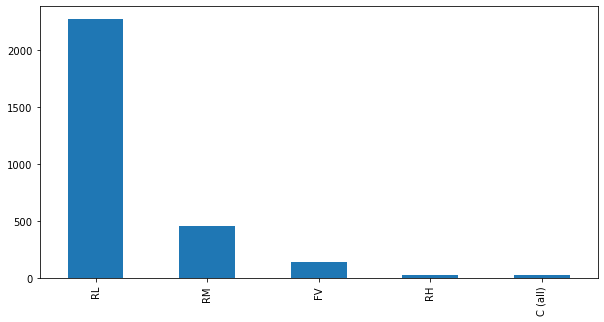

In [19]:
#ploting the graphs to find variance in columns

categorical['MSZoning'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['MSZoning'].value_counts()

Pave    2907
Grvl      12
Name: Street, dtype: int64

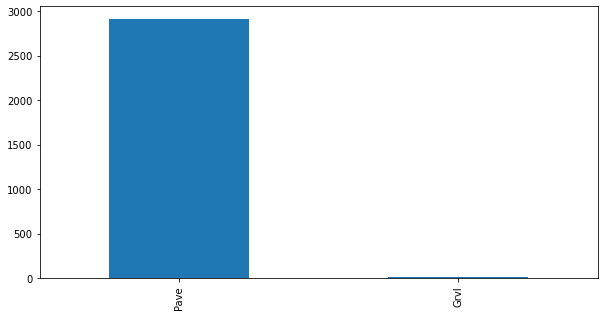

In [20]:
categorical['Street'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Street'].value_counts()

Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64

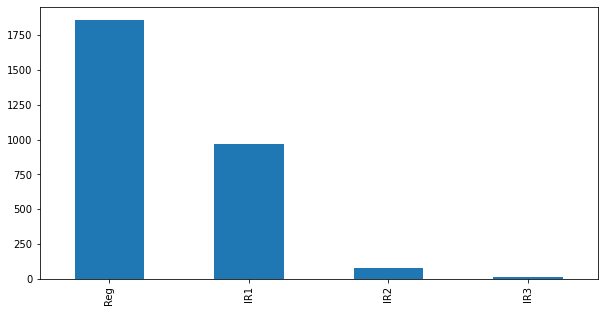

In [21]:
categorical['LotShape'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['LotShape'].value_counts()

Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64

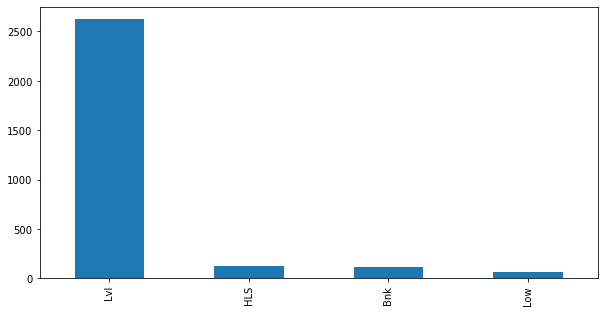

In [22]:
categorical['LandContour'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['LandContour'].value_counts()

AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64

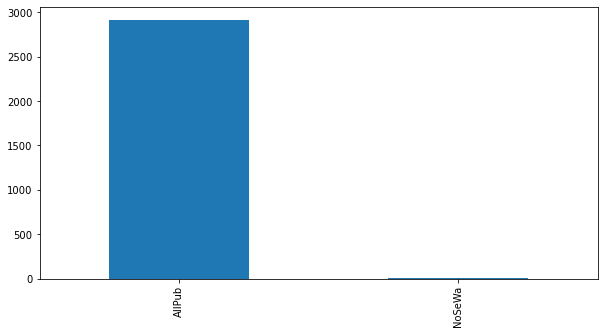

In [23]:
categorical['Utilities'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Utilities'].value_counts()

Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

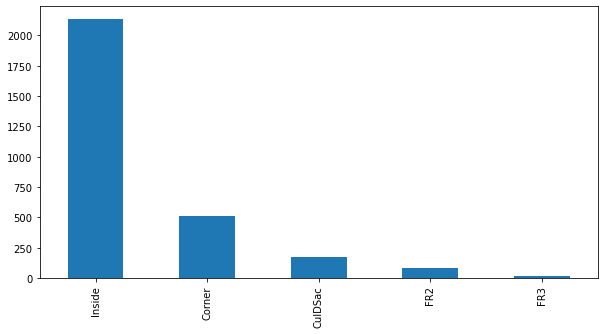

In [24]:
categorical['LotConfig'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['LotConfig'].value_counts()

Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64

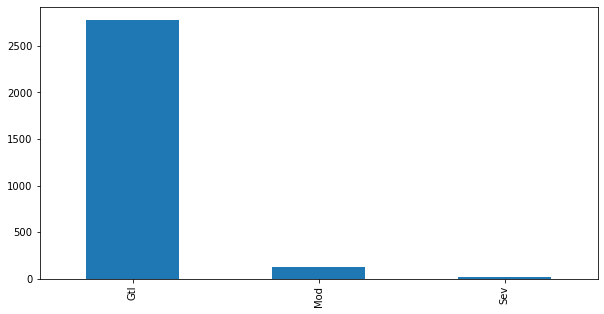

In [25]:
categorical['LandSlope'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['LandSlope'].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64

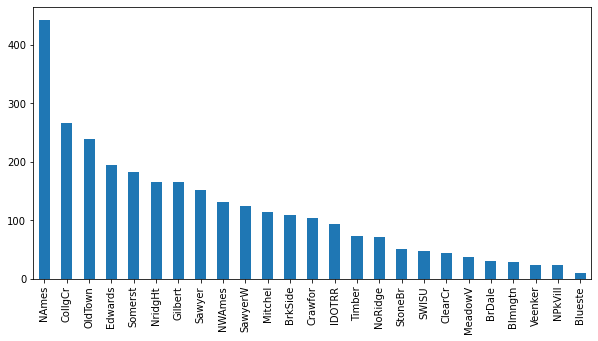

In [26]:
categorical['Neighborhood'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Neighborhood'].value_counts()

Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

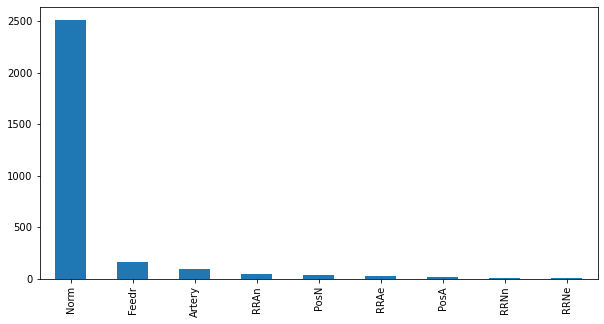

In [27]:
categorical['Condition1'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Condition1'].value_counts()

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

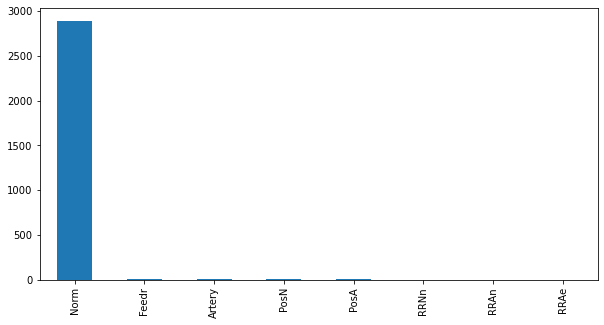

In [28]:
categorical['Condition2'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Condition2'].value_counts()

1Fam      2425
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64

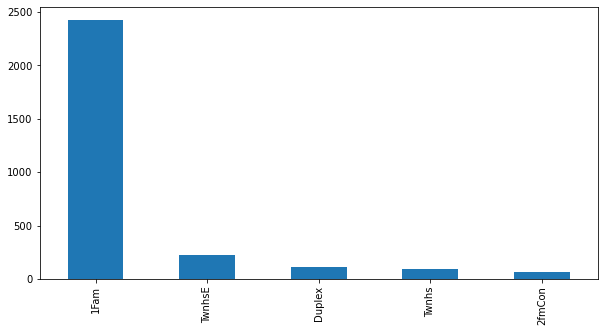

In [29]:
categorical['BldgType'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['BldgType'].value_counts()

1Story    1471
2Story     872
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64

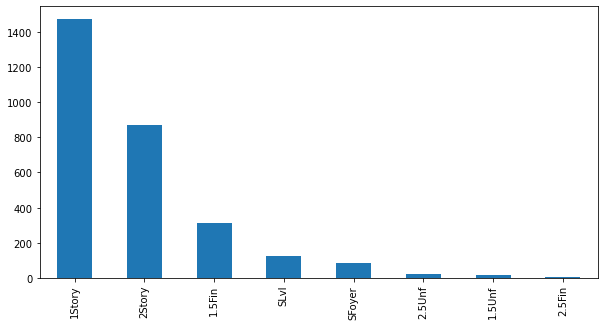

In [30]:
categorical['HouseStyle'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['HouseStyle'].value_counts()

Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64

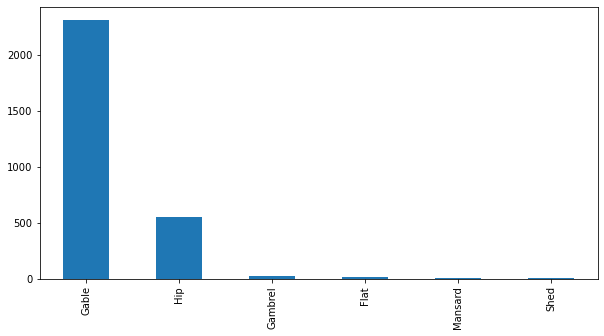

In [31]:
categorical['RoofStyle'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['RoofStyle'].value_counts()

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Metal         1
Roll          1
ClyTile       1
Membran       1
Name: RoofMatl, dtype: int64

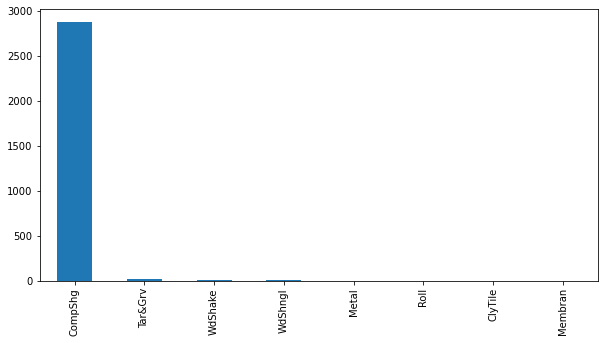

In [32]:
categorical['RoofMatl'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['RoofMatl'].value_counts()

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
Stone         2
AsphShn       2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64

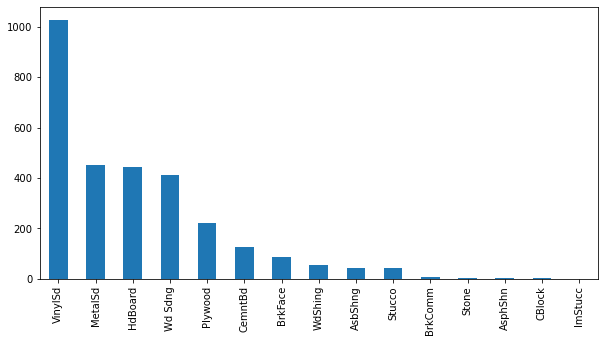

In [33]:
categorical['Exterior1st'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Exterior1st'].value_counts()

VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

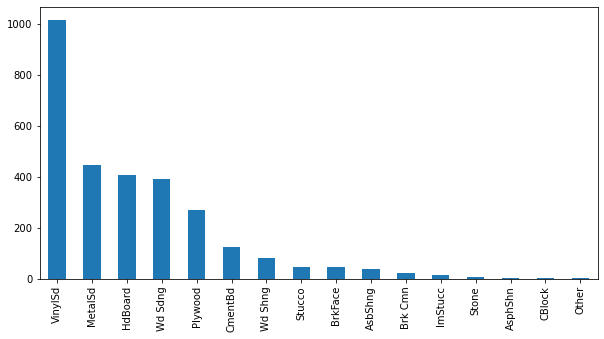

In [34]:
categorical['Exterior2nd'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Exterior2nd'].value_counts()

None       1766
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

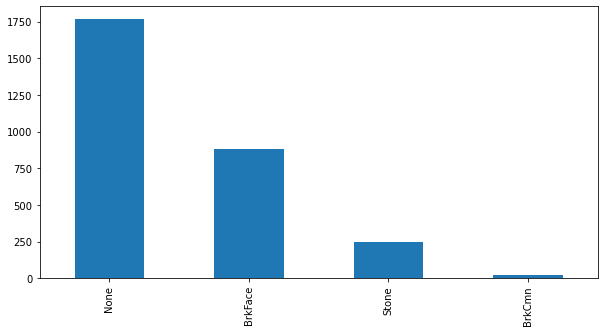

In [35]:
categorical['MasVnrType'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['MasVnrType'].value_counts()

TA    1798
Gd     979
Ex     107
Fa      35
Name: ExterQual, dtype: int64

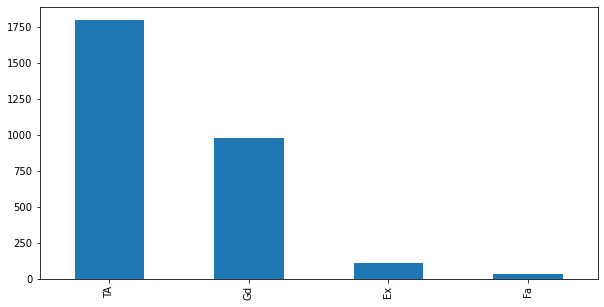

In [36]:
categorical['ExterQual'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['ExterQual'].value_counts()

TA    2538
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64

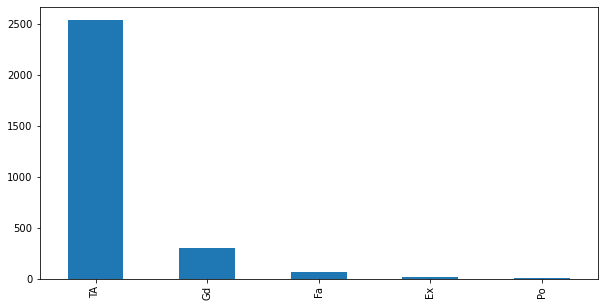

In [37]:
categorical['ExterCond'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['ExterCond'].value_counts()

PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64

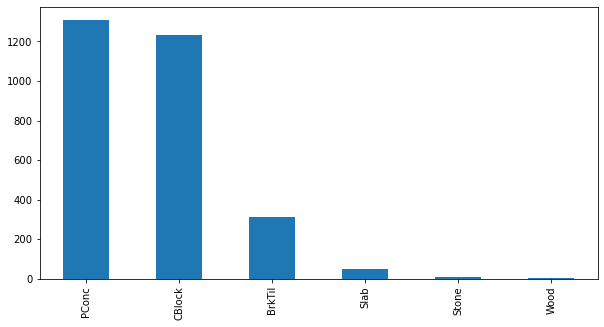

In [38]:
categorical['Foundation'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Foundation'].value_counts()

TA      1283
Gd      1209
Ex       258
Fa        88
None      81
Name: BsmtQual, dtype: int64

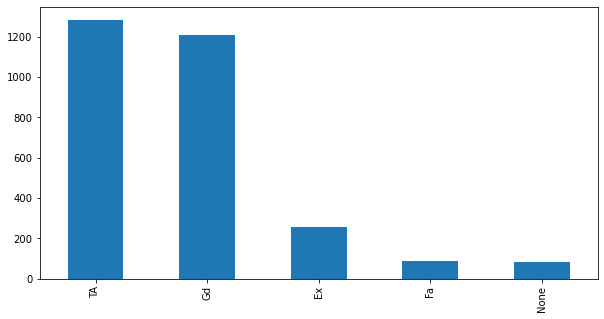

In [39]:
categorical['BsmtQual'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['BsmtQual'].value_counts()

TA      2606
Gd       122
Fa       104
None      82
Po         5
Name: BsmtCond, dtype: int64

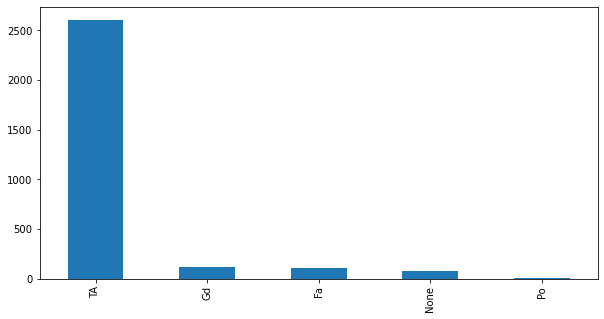

In [40]:
categorical['BsmtCond'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['BsmtCond'].value_counts()

No      1904
Av       418
Gd       276
Mn       239
None      82
Name: BsmtExposure, dtype: int64

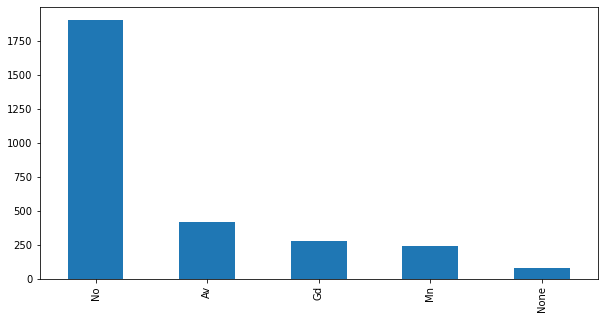

In [41]:
categorical['BsmtExposure'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['BsmtExposure'].value_counts()

Unf     851
GLQ     849
ALQ     429
Rec     288
BLQ     269
LwQ     154
None     79
Name: BsmtFinType1, dtype: int64

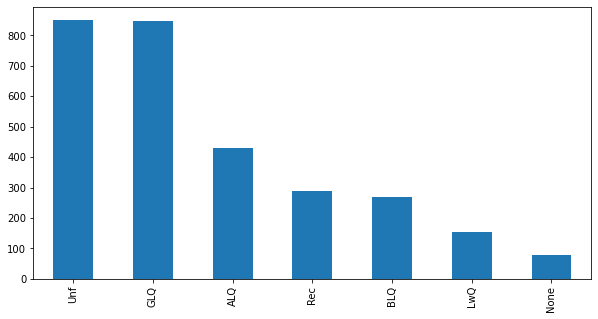

In [42]:
categorical['BsmtFinType1'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['BsmtFinType1'].value_counts()

Unf     2493
Rec      105
LwQ       87
None      80
BLQ       68
ALQ       52
GLQ       34
Name: BsmtFinType2, dtype: int64

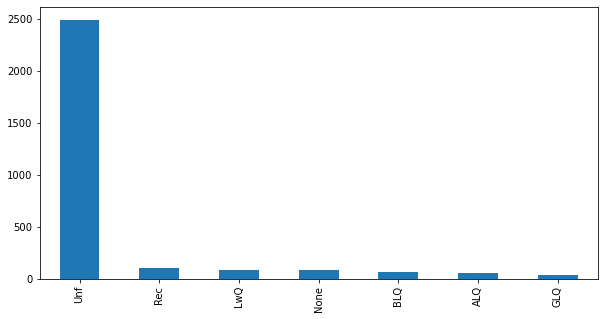

In [43]:
categorical['BsmtFinType2'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['BsmtFinType2'].value_counts()

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

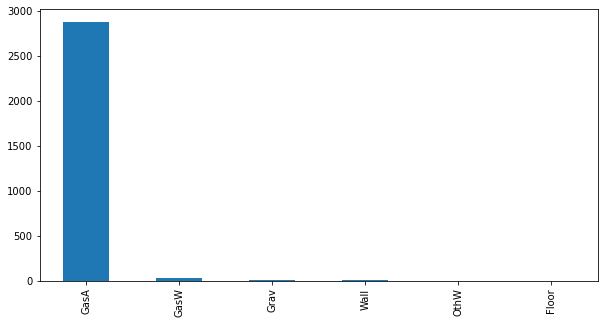

In [44]:
categorical['Heating'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Heating'].value_counts()

Ex    1493
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64

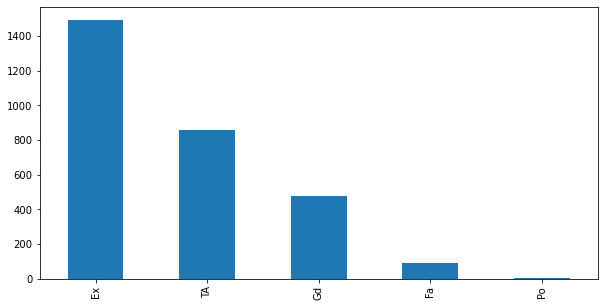

In [45]:
categorical['HeatingQC'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['HeatingQC'].value_counts()

Y    2723
N     196
Name: CentralAir, dtype: int64

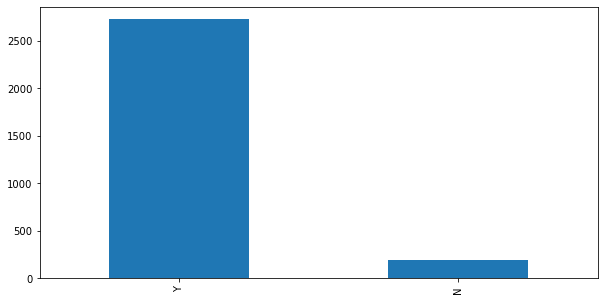

In [46]:
categorical['CentralAir'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['CentralAir'].value_counts()

SBrkr    2672
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

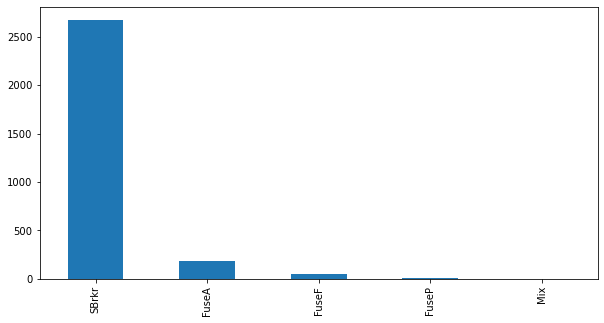

In [47]:
categorical['Electrical'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Electrical'].value_counts()

TA    1493
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

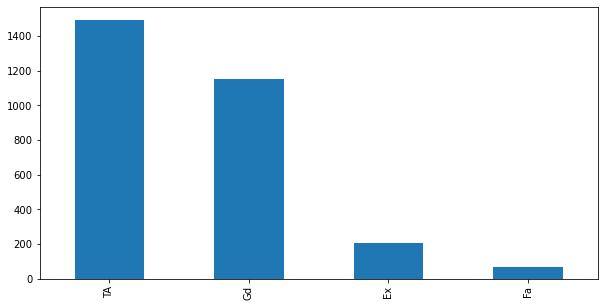

In [48]:
categorical['KitchenQual'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['KitchenQual'].value_counts()

Typ     2719
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

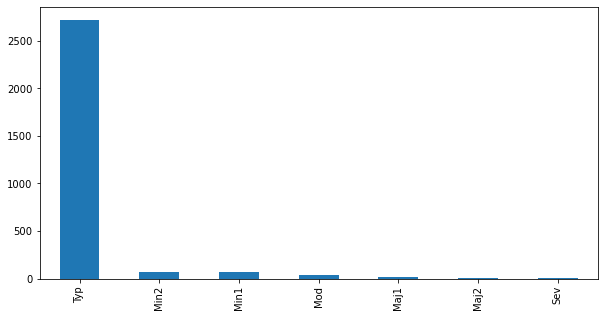

In [49]:
categorical['Functional'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['Functional'].value_counts()

None    1420
Gd       744
TA       592
Fa        74
Po        46
Ex        43
Name: FireplaceQu, dtype: int64

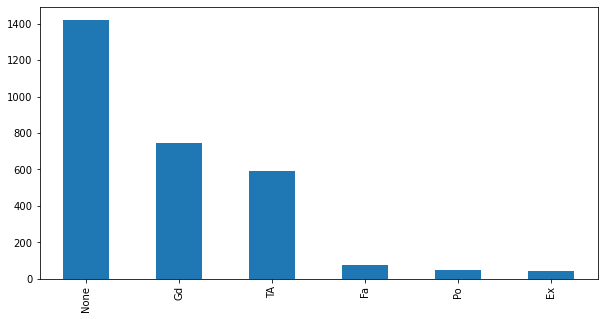

In [50]:
categorical['FireplaceQu'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['FireplaceQu'].value_counts()

Attchd     1723
Detchd      779
BuiltIn     186
None        157
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64

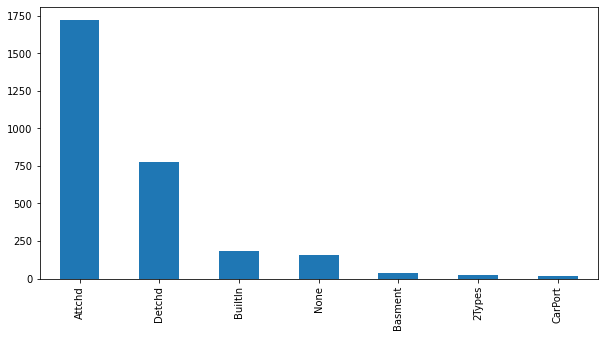

In [51]:
categorical['GarageType'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['GarageType'].value_counts()

Unf     1230
RFn      811
Fin      719
None     159
Name: GarageFinish, dtype: int64

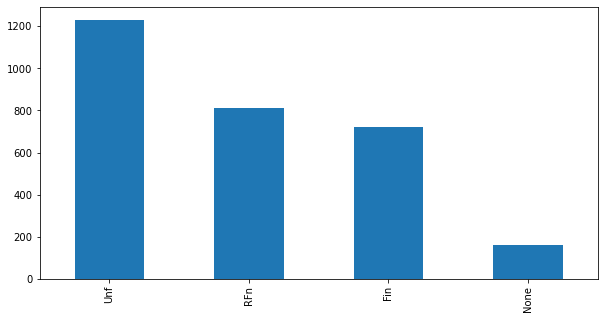

In [52]:
categorical['GarageFinish'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['GarageFinish'].value_counts()

TA      2604
None     159
Fa       124
Gd        24
Po         5
Ex         3
Name: GarageQual, dtype: int64

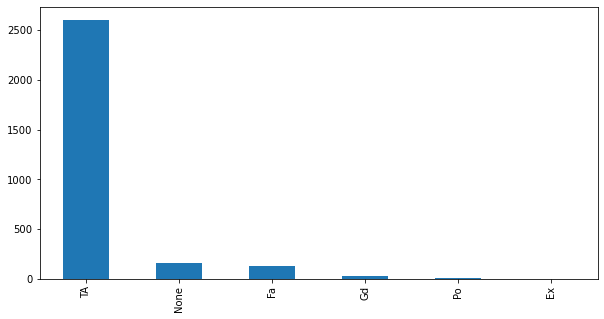

In [53]:
categorical['GarageQual'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['GarageQual'].value_counts()

TA      2654
None     159
Fa        74
Gd        15
Po        14
Ex         3
Name: GarageCond, dtype: int64

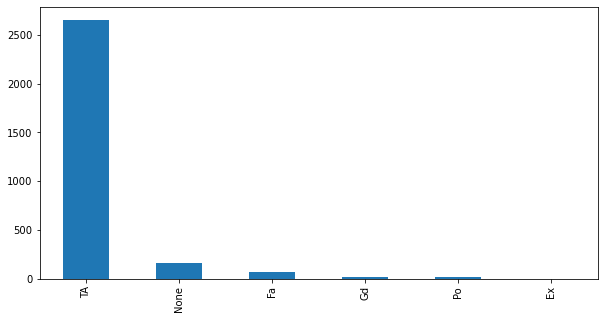

In [54]:
categorical['GarageCond'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['GarageCond'].value_counts()

Y    2641
N     216
P      62
Name: PavedDrive, dtype: int64

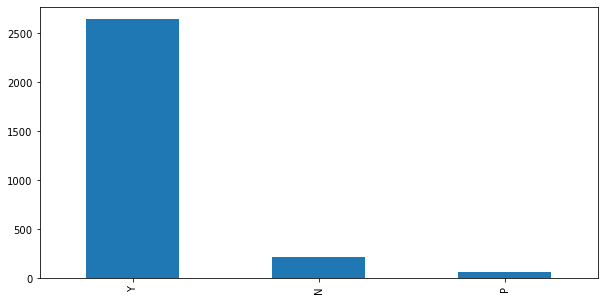

In [55]:
categorical['PavedDrive'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['PavedDrive'].value_counts()

WD       2526
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

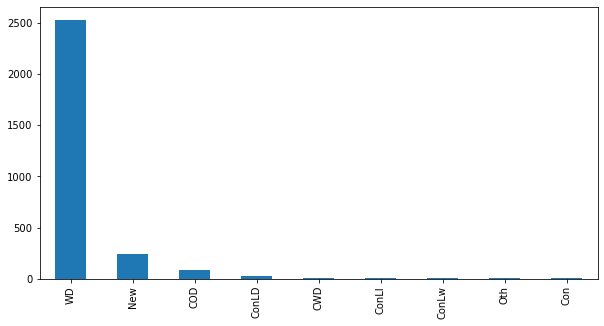

In [56]:
categorical['SaleType'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['SaleType'].value_counts()

Normal     2402
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: SaleCondition, dtype: int64

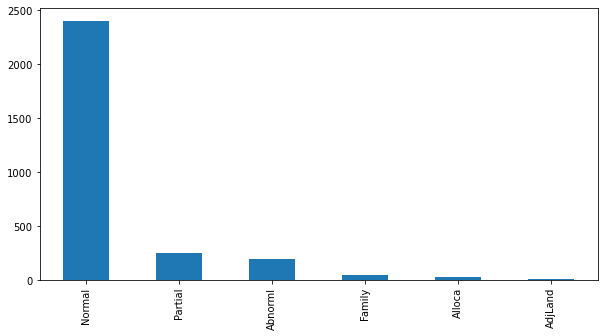

In [57]:
categorical['SaleCondition'].value_counts().plot(kind = 'bar',figsize = [10,5])
categorical['SaleCondition'].value_counts()

In [58]:
#droping the columns with low variation
categorical = categorical.drop(['Street','Utilities','Condition2','RoofMatl','Heating'], axis=1)

In [59]:
#Creating new features 
numerical['House Age'] = numerical['YrSold'] - numerical['YearBuilt']
numerical['House Age'].describe()

count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: House Age, dtype: float64

In [60]:
#To find the negative min value

numerical[numerical['House Age'] < 0]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,House Age
1089,2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,...,0,0,0,0,17000,10,2007,0.0,0,-1


In [61]:
#To fix Data error that is YearBuilt = 2008, YearRemodAdd = 2009 and YrSold = 2007 so changing the YrSold = 2009 

numerical.loc[numerical['YrSold'] < numerical['YearBuilt'],'YrSold'] = 2009

In [62]:
numerical['TotBsmtBath'] = numerical['BsmtFullBath'] + numerical['BsmtHalfBath'] * 0.5
numerical['TotBath'] = numerical['FullBath'] + numerical['HalfBath'] * 0.5
numerical['TotSA'] = numerical['TotalBsmtSF'] + numerical['1stFlrSF'] + numerical['2ndFlrSF']

In [63]:
numerical.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,House Age,TotBsmtBath,TotBath,TotSA
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,2,2008,208500.0,1,5,1.0,2.5,2566.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,5,2007,181500.0,1,31,0.5,2.0,2524.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,9,2008,223500.0,1,7,1.0,2.5,2706.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,2,2006,140000.0,1,91,1.0,1.0,2473.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,12,2008,250000.0,1,8,1.0,2.5,3343.0


In [64]:
categorical.head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,...,Gd,Typ,None,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,Gable,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,Gable,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,Gable,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [65]:
#Encodeing the Categorical Values which are quantifiable

encoder = {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0, 'None':0, 
           'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0, 
           'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'None':0,
           'Y':1, 'N':0,'None':0}

bsmExpo ={'Gd':4,'Av':3, 'Mn':2, 'No':1, 'None':0}

paved = {'Y':2, 'P':1, 'N':0, 'None':0}

categorical['LotShape'] = categorical['LotShape'].map(encoder)
categorical['ExterQual'] = categorical['ExterQual'].map(encoder)
categorical['ExterCond'] = categorical['ExterCond'].map(encoder)
categorical['BsmtCond'] = categorical['BsmtCond'].map(encoder)
categorical['BsmtQual'] = categorical['BsmtQual'].map(encoder)
categorical['BsmtExposure'] = categorical['BsmtExposure'].map(bsmExpo)
categorical['HeatingQC'] = categorical['HeatingQC'].map(encoder)
categorical['KitchenQual'] = categorical['KitchenQual'].map(encoder)
categorical['FireplaceQu'] = categorical['FireplaceQu'].map(encoder)
categorical['GarageQual'] = categorical['GarageQual'].map(encoder)
categorical['GarageCond'] = categorical['GarageCond'].map(encoder)
categorical['BsmtFinType1'] = categorical['BsmtFinType1'].map(encoder)
categorical['BsmtFinType2'] = categorical['BsmtFinType2'].map(encoder)
categorical['CentralAir'] = categorical['CentralAir'].map(encoder)
categorical['PavedDrive'] = categorical['PavedDrive'].map(paved)


In [66]:
#Encodeing the Categorical Values which are not quantifiable 
#unsing hot encoder to encode the rest of categorical features

rest_categorical = categorical.select_dtypes(include=['object'])
categorical = pd.get_dummies(categorical, columns=rest_categorical.columns)

In [67]:
categorical.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3,4,3,4,3,1,6,1,5,1,...,0,0,0,1,0,0,0,0,1,0
1,3,3,3,4,3,4,5,1,5,1,...,0,0,0,1,0,0,0,0,1,0
2,2,4,3,4,3,2,6,1,5,1,...,0,0,0,1,0,0,0,0,1,0
3,2,3,3,3,4,1,5,1,4,1,...,0,0,0,1,1,0,0,0,0,0
4,2,4,3,4,3,3,6,1,5,1,...,0,0,0,1,0,0,0,0,1,0


In [68]:
#Combining both categorical and numerical features

df_final = pd.concat([categorical,numerical], axis =1, sort=False)
df_final.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,House Age,TotBsmtBath,TotBath,TotSA
0,3,4,3,4,3,1,6,1,5,1,...,0,0,2,2008,208500.0,1,5,1.0,2.5,2566.0
1,3,3,3,4,3,4,5,1,5,1,...,0,0,5,2007,181500.0,1,31,0.5,2.0,2524.0
2,2,4,3,4,3,2,6,1,5,1,...,0,0,9,2008,223500.0,1,7,1.0,2.5,2706.0
3,2,3,3,3,4,1,5,1,4,1,...,0,0,2,2006,140000.0,1,91,1.0,1.0,2473.0
4,2,4,3,4,3,3,6,1,5,1,...,0,0,12,2008,250000.0,1,8,1.0,2.5,3343.0


In [69]:
#seperating test and train data set

df_final = df_final.drop(['Id'],axis=1)

df_train = df_final[df_final['train']==1]
df_train = df_train.drop(['train'],axis=1)

df_test = df_final[df_final['train']==0]
df_test = df_test.drop(['SalePrice'],axis=1)
df_test = df_test.drop(['train'],axis=1)

In [70]:
#Seperating the saleprice from the train dataset

saleprice = df_train['SalePrice']
df_train = df_train.drop(['SalePrice'], axis=1)

In [71]:
#Modeling

x_train,x_test,y_train,y_test = train_test_split(df_train,saleprice,test_size=0.33,random_state =0)

In [72]:
xgb = XGBRegressor(booster='gbtree',
                   verbosity=1,
                   max_depth=4,
                   colsample_bytree=0.6,
                   reg_lambda=0.6,
                   aplha=0.6,
                   eta=0.01, 
                   nthread=None, 
                   n_estimators=24000)

lgbm = LGBMRegressor(objective='regression',
                     num_leaves=4,
                     learning_rate=0.01,
                     n_estimators=12000,
                     bagging_fraction=0.75, 
                     bagging_freq=5,
                     bagging_seed=7,
                     feature_fraction=0.4)

In [73]:
#Test fitting

xgb.fit(x_train,y_train)
lgbm.fit(x_train,y_train,eval_metric='rmse')

[12:29:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { aplha } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, n_estimators=12000,
              num_leaves=4, objective='regression')

In [74]:
p1=xgb.predict(x_test)
p2=lgbm.predict(x_test)

In [75]:
math.sqrt(metrics.mean_squared_error(y_test,p1))

25639.147528996098

In [76]:
math.sqrt(metrics.mean_squared_error(y_test,p2))

27118.341792229403

In [ ]:
#Fitting with all the dataset

xgb.fit(df_train,saleprice)
lgbm.fit(df_train,saleprice,eval_metric='rmse')

[12:30:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { aplha } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [ ]:
#Predicting the final salesprice of the house

p3=xgb.predict(df_test)
p4=lgbm.predict(df_test)
predict_final = (p3*.5 + p4*.5)

In [ ]:
submission = pd.DataFrame({"Id":test['Id'],"SalePrice":predict_final})
submission.to_csv('submission.csv',index=False)

In [ ]:
submission.head()